In [1]:
%load_ext autoreload 
%autoreload 2  

# Modules preprocessing
import os
import sys
import glob
import numpy as np
import pandas as pd
import cv2

import math
import string
import random
import shutil

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F

# Modules DenseNet
#from IPython.display import Image 
import matplotlib.pyplot as plt
from PIL import Image

# from utilities import training as tr
# from utilities import images as im

# import camvid
# import densenet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Setup
import torch  
import torch.nn as nn
import torchvision  
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate, dropout):
        """
        DenseLayer with the following operations:
        1. BatchNorm -> ReLU -> 1x1 Convolution
        2. (Optional): Dropout

        Arguments:
        x: input tensor

        Return: 
        x: output tensor
        """
        super().__init__()

        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
        self.add_module('conv', nn.Conv2d(in_channels, 
                                          growth_rate, 
                                          kernel_size=3,
                                          stride=1, 
                                          padding=1, 
                                          bias=True))
        if dropout != 0.0:
            self.add_module('drop', nn.Dropout2d(dropout))

    def forward(self, x):
        
        return super().forward(x)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, dropout, upsample=False):
        """
        Looping through total number of layers in the denseblock.
        Adding k number of channels in each loop as each layer generates tensor.
        
        Arguments: 
            in_channels (int): input number of channels.
            growth_rate (int): growth ratio.
            n_layers (int): total number of layers in the dense block
            dropout (float): dropout parameter
        """
        super().__init__()

        self.upsample = upsample
        self.layers   = nn.ModuleList([])
        # Loop over all layers in a block
        for i in range(n_layers):
            self.layers.append(DenseLayer(in_channels + i * growth_rate,
                                          growth_rate,
                                          dropout))

    def forward(self, x):
        """
        Args: 
            x (tensor): input tensor
            
        Return:
            x (tensor): output tensor
        """
        # For upsample Dense Blocks:
        if self.upsample:
            new_features = []

            # Loop over all layers in Dense Block
            for layer in self.layers: 
                # Put data through layer
                out = layer(x)
                # Concatenate output to input
                x = torch.cat([x, out], 1)
                # Append output to new_features
                new_features.append(out)
                
            return torch.cat(new_features, 1)
        # For downsample Dense Blocks:
        else:
            for layer in self.layers:
                # Put data through layer
                out = layer(x)
                # Concatenate output to input
                x = torch.cat([x, out], 1)

            return x
        

class TransitionDown(nn.Sequential):
    def __init__(self, in_channels, dropout):
        super().__init__()

        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                                          out_channels=in_channels,
                                          kernel_size=1, 
                                          stride=1,
                                          padding=0, 
                                          bias=True))
        if dropout != 0.0:
            self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))

    def forward(self, x):
        """
        Arguments:
        x (tensor): input tensor
        
        Return:
        x: (tensor): output tensor
        """
        return super().forward(x)


class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
                                            out_channels=out_channels,
                                            kernel_size=3, 
                                            stride=2, 
                                            padding=0, 
                                            bias=True)

    def forward(self, x, skip):
        """
        Arguments:
        x (tensor): input tensor
        
        Return:
        x: (tensor): output tensor
        """
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out


class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers, dropout):
        super().__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, 
                                                 growth_rate, 
                                                 n_layers, 
                                                 dropout, 
                                                 upsample=True))

    def forward(self, x):
        return super().forward(x)


def center_crop(layer, max_height, max_width):
    _, _, h, w = layer.size()
    xy1 = (w - max_width) // 2
    xy2 = (h - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]



class DenseNet(nn.Module):
    def __init__(self, in_channels, down_blocks, up_blocks, bottleneck_layers,
                 growth_rate=16, out_chans_first_conv=48, n_classes=32, dropout=0.2):
        super().__init__()

        self.down_blocks    = down_blocks
        self.up_blocks      = up_blocks
        cur_channels_count  = 0
        skip_connection_channel_counts = []

        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                                               out_channels=out_chans_first_conv, 
                                               kernel_size=3,
                                               stride=1, 
                                               padding=1, 
                                               bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])

        # For every stage in the down_blocks variant ([4, 5, 7, 10, 12])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(DenseBlock(cur_channels_count, 
                                                   growth_rate, 
                                                   down_blocks[i], 
                                                   dropout))
            # Update input channels count with growth size * [4, 5, 7, 10, 12]
            cur_channels_count += (growth_rate * down_blocks[i]) # 48 -> 112 -> 192 -> 304 -> 464 -> 656 channels
            # Update skip connections with current channel at index = 0 for later at upsampling
            skip_connection_channel_counts.insert(0, cur_channels_count) # [656, 464, 304, 192, 112, 48]
            # Add Transition Down Block to transitionDown module list
            self.transDownBlocks.append(TransitionDown(cur_channels_count, 
                                                       dropout))

        #####################
        #     Bottleneck    #
        #####################

        # Create Bottleneck module
        self.add_module('bottleneck', Bottleneck(cur_channels_count,
                                                 growth_rate, 
                                                 bottleneck_layers, 
                                                 dropout))
        # Num channels BottleNeck
        prev_block_channels = growth_rate * bottleneck_layers # 240 channels
        # Add these to current channel count
        cur_channels_count += prev_block_channels # 896 channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])

        # Loop over all up_blocks
        for i in range(len(up_blocks)-1):
            # Add TransitionUp to ModuleList. 
            self.transUpBlocks.append(TransitionUp(prev_block_channels, 
                                                   prev_block_channels))
            # The previous input is not concatenated anymore, so output_channels = prev_block_channels
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]
            # Add Dense Block to ModuleList
            self.denseBlocksUp.append(DenseBlock(cur_channels_count, 
                                                 growth_rate, 
                                                 up_blocks[i], 
                                                 dropout,
                                                 upsample=True))
            # Num channels last Dense Block
            prev_block_channels = growth_rate * up_blocks[i]
            # Add these to current channel count
            cur_channels_count += prev_block_channels

        #######################
        #   Final DenseBlock  #
        #######################

        # Add TransitionUp to ModuleList
        self.transUpBlocks.append(TransitionUp(prev_block_channels, 
                                               prev_block_channels))
        # Add num channels last Block + num channels from last skip connection to num current channels
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]
        # Add Dense Block to ModuleList
        self.denseBlocksUp.append(DenseBlock(cur_channels_count, 
                                             growth_rate, 
                                             up_blocks[-1], 
                                             dropout,
                                             upsample=False))
        # Add these to current channel count
        cur_channels_count += growth_rate * up_blocks[-1]

        #######################
        #       Softmax       #
        #######################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
                                   out_channels=n_classes, 
                                   kernel_size=1, 
                                   stride=1,
                                   padding=0, 
                                   bias=True)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # First convolutional layer
        out = self.firstconv(x)
        # Initialize list for skip connections 
        skip_connections = []

        # Loop over blocks in down_blocks
        for block in range(len(self.down_blocks)):
            # Put data through current Dense Block
            out = self.denseBlocksDown[block](out)
            # Save the output in the skip connections list for later
            skip_connections.append(out)
            # Put data through current Transision Down Block
            out = self.transDownBlocks[block](out)  

        out = self.bottleneck(out)

        # Loop over blocks in up_blocks
        for i in range(len(self.up_blocks)):
            # Get the last skip from skip_connections
            skip = skip_connections.pop()
            # Put data through current Transition Up Block with last skip connections
            out = self.transUpBlocks[i](out, skip)
            # Put data through current Dense Block
            out = self.denseBlocksUp[i](out)

        # Put data through final convolution and softmax layers
        out = self.finalConv(out)
        out = self.softmax(out)
        
        return out

In [3]:
from pathlib import Path


class CamVid():
    def __init__(self, type_image, input_path, classes, shape, color_id, image_transform, label_transform): 
        self.input_path         = input_path
        #self.joint_transform    = joint_transform
        self.image_transform    = image_transform
        self.label_transform    = label_transform
        self.shape              = shape
        self.color_id           = color_id
        self.classes            = classes
        
        self.images_paths       = sorted(glob.glob(os.path.join(input_path, type_image, '*.png')))
        self.labels_paths       = sorted(glob.glob(os.path.join(input_path, type_image + '_labels', '*.png')))

        self.images = self.make_dataset(self.images_paths) 
        self.labels = self.make_dataset(self.labels_paths) 

    def make_dataset(self, file_paths):
        dataset = []
        for file_path in file_paths:
            img = Image.open(file_path)
            dataset.append(np.array(img))
        return dataset

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.resize(image, self.shape)
        label = cv2.resize(label, self.shape)

        image = self.image_transform(image)
        
        label = self.color_map_labels(label, self.color_id)
        label = self.label_transform(label).squeeze(0)

        return image, label

    def color_map_labels(self, label, color_id):
        result = np.zeros_like(label, dtype=np.uint8)
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                try:
                    result[i, j] = color_id[tuple(label[i, j])]
                except KeyError:
                    result[i, j] = color_id[tuple(np.array([0, 0, 0]))]  
        return result[..., 0:1]

In [4]:
def load_color_label(path):
    # Get path to class dictionary
    class_dict_path = os.path.join(path, 'class_dict.csv') 
    
    # Read classes and rgb 
    classes = pd.read_csv(class_dict_path)['name'].values
    rgb     = pd.read_csv(class_dict_path)[['r', 'g', 'b']].values

    # Assign ID to color codes
    color_id = {tuple(v):k for k, v in enumerate(rgb)}

    return classes, rgb, color_id
    
def view_annotated(tensor, color_id, plot=True, target=True):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.cpu().numpy() 

    # Create an empty array for the reconstructed image
    height, width = tensor.shape
    reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Create a reverse dictionary mapping IDs to colors
    id_color_dict = {v: k for k, v in color_id.items()}

    # Map each ID to the corresponding color
    for i in range(height):
        for j in range(width):
            pixel_id = tensor[i, j]
            reconstructed_image[i, j] = id_color_dict[pixel_id]

    plt.imshow(reconstructed_image)
    plt.show()        
    
def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = [0.41189489566336, 0.4251328133025, 0.4326707089857]
    std = [0.27413549931506, 0.28506257482912, 0.28284674400252]
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    inp = decode_image(tensor)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

class ToLongTensor(object):
    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            pic = np.transpose(pic, (2, 0, 1)) 
            label = torch.from_numpy(pic).long()
        else:
            label = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            label = label.view(1, pic.size[1], pic.size[0])
            label = label.transpose(0, 1).transpose(0, 2).squeeze().contiguous().long()
        return label

In [5]:
def save_weights(model, WEIGHTS_PATH, epoch, loss, err):
    weights_fname = 'weights-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest.th')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    weights = torch.load(fpath)
    startEpoch = weights['startEpoch']
    model.load_state_dict(weights['state_dict'])
    print("loaded weights (lastEpoch {}, loss {}, error {})"
          .format(startEpoch-1, weights['loss'], weights['error']))
    return startEpoch

def get_predictions(output_batch):
    N, C, H, W = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(N, H, W)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    N, H, W = preds.size()
    n_pixels = N * H * W
    incorrect = preds.ne(targets).cpu().sum()
    err = incorrect.item() / n_pixels
    return round(err, 5)

def train(model, trn_loader, optimizer, criterion, epoch):
    model.train()
    trn_loss = 0
    trn_error = 0
    count = 0
    for idx, data in enumerate(trn_loader):
        inputs = Variable(data[0].cuda())
        targets = Variable(data[1].cuda())

        optimizer.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        trn_loss += loss.item()
        pred = get_predictions(output)
        trn_error += error(pred, targets.data.cpu())
        count += 1

    trn_loss /= len(trn_loader)
    trn_error /= len(trn_loader)
    return trn_loss, trn_error

def test(model, test_loader, criterion, epoch=1, print_IoU=False):
    n_classes = 32
    model.eval()
    test_loss = 0
    test_error = 0
    
    total_I = torch.zeros(n_classes, dtype=torch.float32)
    total_U = torch.zeros(n_classes, dtype=torch.float32)

    IoU = torch.zeros(n_classes, dtype=torch.float32)
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            pred = torch.argmax(output, dim=1)            
            
            test_error += (pred != target).float().mean().item()
            
            for i in range(data.size(0)):
                pred_single = pred[i]  
                target_single = target[i] 

                # Compute IoU for this single image
                I, U = calculateIoU(pred_single, target_single, n_classes)
                total_I += I
                total_U += U

    test_loss /= len(test_loader)
    test_error /= len(test_loader)
    
    for i in range(n_classes):
        if total_U[i] != 0:
            IoU[i] = total_I[i] / (total_U[i]) * 100
            
    
    IoU = IoU.round()
    mean_IoU = IoU[IoU > 1].mean().item()  # Only consider classes with non-zero union

    if print_IoU:
        print(IoU)
    return test_loss, test_error, mean_IoU

def adjust_learning_rate(lr, decay, optimizer, current_epoch, n_epochs):
    """Sets the learning rate to the initially
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (current_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight)
        m.bias.data.zero_()

def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    predictions = []
    model.eval()
    for input, target in input_loader:
        data = Variable(input.cuda())
        label = Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

def view_sample_predictions(model, loader, color_id, n, output_images=False):
    inputs, targets = next(iter(loader))
    data = Variable(inputs.cuda())
    label = Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(min(n, batch_size)):
        view_image(inputs[i])

        view_annotated(targets[i], color_id)
        view_annotated(pred[i], color_id)
        IoU = meanIoU(targets[i], pred[i], 32)
        print(f"IoU for sample {i}: {IoU}")
        
        if output_images:
            plt.imsave(f'/kaggle/working/input-{IoU}.jpg', inputs[i])
            plt.imsave(f'/kaggle/working/target-{IoU}.jpg', targets[i])
            plt.imsave(f'/kaggle/working/pred-{IoU}.jpg', pred[i])
        

def calculateIoU(prediction, target, n_classes):
    """
    Returns the intersection I and union U
    Args:
        prediction (tensor): tensor of predictions. 
        target (tensor): tensor of label
        n_classes (int): number of classes

    Return: 
        tensors I and U of size (n_classes)
    """
    I = torch.zeros(n_classes, dtype=torch.float32)
    U = torch.zeros(n_classes, dtype=torch.float32)
    IoU = torch.zeros(n_classes, dtype=torch.float32)

    for i in range(n_classes):
        target_i = (target == i)
        prediction_i = (prediction == i)
        
        I[i] = torch.logical_and(prediction_i, target_i).sum().item()
        U[i] = torch.logical_or(prediction_i, target_i).sum().item()
        
        if U[i] > 0.0:
            IoU[i] = I[i] / U[i]

    return I, U

def meanIoU(prediction, target, n_classes):
    I, U = calculateIoU(prediction, target, n_classes)
    IoU = I / U
    mean_IoU = IoU[U > 0.00].mean() * 100 # Calculate mean IoU for classes with non-zero union
    return mean_IoU

In [6]:
input_path      = '/kaggle/input/camvid/CamVid'
output_path     = '/kaggle/working/output1'
Path(output_path).mkdir(parents=True, exist_ok=True)
image_height1   = 224
image_width1    = 224
image_height2   = 352
image_width2    = 480 

In [7]:
classes, rgb, color_id = load_color_label(input_path)  

In [8]:
mean = [0.41189489566336, 0.4251328133025, 0.4326707089857]
std = [0.27413549931506, 0.28506257482912, 0.28284674400252]

normalize = transforms.Normalize(mean=mean, std=std)

image_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

labels_transform = transforms.Compose([
    ToLongTensor(),
])

shape_224x224 = (224, 224)
shape_360x480 = (480, 352)


In [9]:
train_images_224x224    = CamVid('train', input_path, classes, shape_224x224, color_id, image_transform, labels_transform)
test_images_224x224     = CamVid('test', input_path, classes, shape_224x224, color_id, image_transform, labels_transform)
val_images_224x224      = CamVid('val', input_path, classes, shape_224x224, color_id, image_transform, labels_transform)

batch_size_224x224 = 4
train_loader_224x224 = torch.utils.data.DataLoader(train_images_224x224, batch_size=batch_size_224x224, shuffle=True)
test_loader_224x224 = torch.utils.data.DataLoader(test_images_224x224, batch_size=batch_size_224x224, shuffle=True)
val_loader_224x224 = torch.utils.data.DataLoader(val_images_224x224, batch_size=batch_size_224x224, shuffle=True)

In [10]:
train_images_360x480    = CamVid('train', input_path, classes, shape_360x480, color_id, image_transform, labels_transform)
test_images_360x480     = CamVid('test', input_path, classes, shape_360x480, color_id, image_transform, labels_transform)
val_images_360x480      = CamVid('val', input_path, classes, shape_360x480, color_id, image_transform, labels_transform)

batch_size_360x480 = 1
train_loader_360x480 = torch.utils.data.DataLoader(train_images_360x480, batch_size=batch_size_360x480, shuffle=True) 
test_loader_360x480 = torch.utils.data.DataLoader(test_images_360x480, batch_size=batch_size_360x480, shuffle=True)
val_loader_360x480 = torch.utils.data.DataLoader(val_images_360x480, batch_size=batch_size_360x480, shuffle=True)

Train: 369
Val: 100
Test: 232
Classes: 32
inputs.shape:  torch.Size([4, 3, 224, 224])
targets.shape:  torch.Size([4, 224, 224])


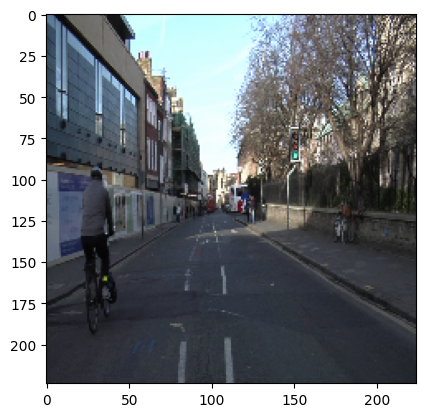

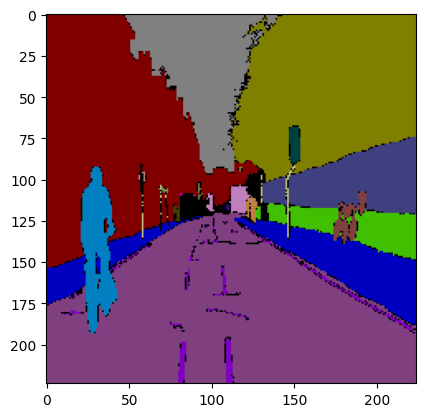

In [11]:
print("Train: %d" %len(train_loader_224x224.dataset.images))
print("Val: %d" %len(val_loader_224x224.dataset.images))
print("Test: %d" %len(test_loader_224x224.dataset.images))
print("Classes: %d" % len(train_loader_224x224.dataset.classes))

mean = [0.41189489566336, 0.4251328133025, 0.4326707089857]
std = [0.27413549931506, 0.28506257482912, 0.28284674400252]

# To get one batch
inputs_224x224, targets_224x224 = next(iter(train_loader_224x224))
print("inputs.shape: ", inputs_224x224.shape)
print("targets.shape: ", targets_224x224.shape)
view_image(inputs_224x224[0])
view_annotated(targets_224x224[0], color_id)


Train: 369
Val: 100
Test: 232
Classes: 32
inputs.shape:  torch.Size([1, 3, 352, 480])
targets.shape:  torch.Size([1, 352, 480])


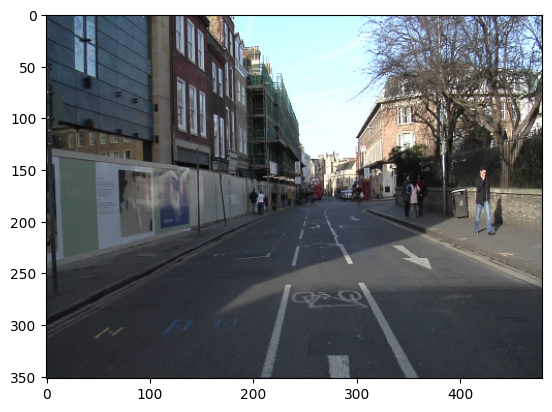

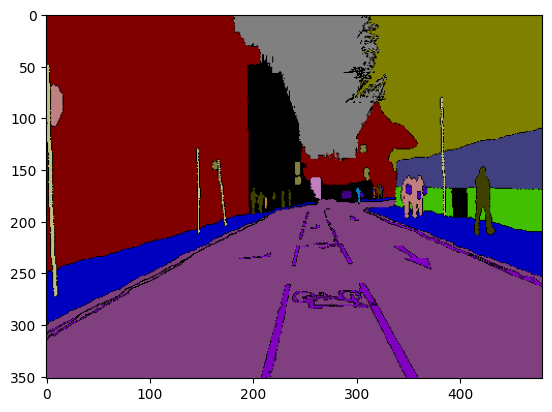

In [12]:
print("Train: %d" %len(train_loader_360x480.dataset.images))
print("Val: %d" %len(val_loader_360x480.dataset.images))
print("Test: %d" %len(test_loader_360x480.dataset.images)) 
print("Classes: %d" % len(train_loader_360x480.dataset.classes))

mean = [0.41189489566336, 0.4251328133025, 0.4326707089857]
std = [0.27413549931506, 0.28506257482912, 0.28284674400252]

# To get one batch
inputs_360x480, targets_360x480 = next(iter(train_loader_360x480))
print("inputs.shape: ", inputs_360x480.shape)
print("targets.shape: ", targets_360x480.shape)
view_image(inputs_360x480[0])
view_annotated(targets_360x480[0], color_id)

In [13]:
densenet103_downblocks = [4, 5, 7, 10, 12]
densenet103_bottleneck = 15
densenet103_upblocks   = [12, 10, 7, 5, 4]
in_channels = 3
growth_rate = 16

model = DenseNet(in_channels=in_channels, down_blocks=densenet103_downblocks, 
                          up_blocks=densenet103_upblocks,
                          bottleneck_layers=densenet103_bottleneck, 
                          growth_rate=growth_rate, 
                          out_chans_first_conv=48,
                          n_classes=32, dropout=0.2).cuda()

In [14]:
RESULTS_PATH = '/kaggle/working/results'
WEIGHTS_PATH = '/kaggle/working/weights'

Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
Path(WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)

In [17]:
LR = 0.001
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS_224x224 = 40

In [ ]:
import time
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss().cuda()

for epoch in range(1, N_EPOCHS_224x224 + 1):
    since = time.time()

    ### Train ###
    train_loss_224x224, train_err_224x224 = train(model, train_loader_224x224, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, train_loss_224x224, 1-train_err_224x224))    

    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss_224x224, val_err_224x224, val_IoU_224x224 = test(model, val_loader_224x224, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss_224x224, 1-val_err_224x224))
    print('Average IoU: ', val_IoU_224x224)
          
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model, WEIGHTS_PATH, epoch, val_loss_224x224, val_err_224x224)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 1.5828, Acc: 0.5923
Train Time 1m 41s
Val - Loss: 1.2369 | Acc: 0.5964
Average IoU:  24.83333396911621
Total Time 2m 2s

Epoch 2
Train - Loss: 1.0652, Acc: 0.6670
Train Time 1m 40s
Val - Loss: 1.1472 | Acc: 0.6447
Average IoU:  26.272727966308594
Total Time 2m 1s

Epoch 3
Train - Loss: 1.0027, Acc: 0.6862
Train Time 1m 40s
Val - Loss: 0.8939 | Acc: 0.7119
Average IoU:  33.153846740722656
Total Time 2m 1s

Epoch 4
Train - Loss: 0.9833, Acc: 0.6929
Train Time 1m 40s
Val - Loss: 0.9339 | Acc: 0.7043
Average IoU:  30.35714340209961
Total Time 2m 1s

Epoch 5
Train - Loss: 0.9227, Acc: 0.7118
Train Time 1m 40s
Val - Loss: 0.8298 | Acc: 0.7443
Average IoU:  33.53333282470703
Total Time 2m 1s

Epoch 6
Train - Loss: 0.8946, Acc: 0.7256
Train Time 1m 40s
Val - Loss: 1.0152 | Acc: 0.6926
Average IoU:  32.41666793823242
Total Time 2m 1s

Epoch 7
Train - Loss: 0.8524, Acc: 0.7402
Train Time 1m 41s
Val - Loss: 0.7796 | Acc: 0.7637
Average IoU:  31.0
Total Time 2m 2s

Epoch 8
Tr

In [25]:
test(model, test_loader_224x224, criterion, epoch=1, print_IoU=True)  

tensor([ 0.,  0., 17.,  0., 68., 27.,  0.,  0., 10., 22., 43.,  0.,  4.,  0.,
        12.,  0.,  7., 81.,  0., 45.,  8., 91.,  0.,  0., 17.,  0., 67.,  0.,
         0., 21., 15.,  8.])


(0.9417488739408296, 0.26040921694245833, 31.27777862548828)

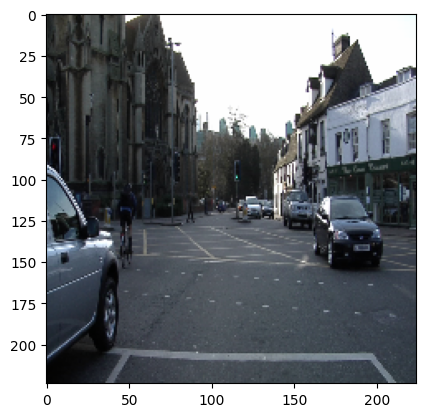

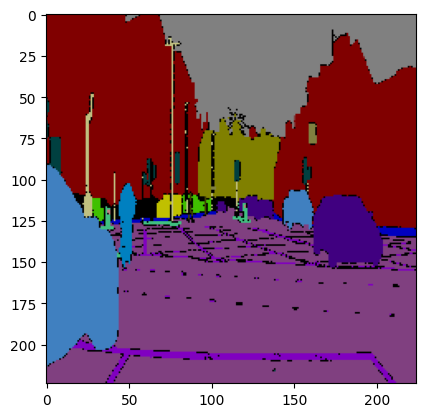

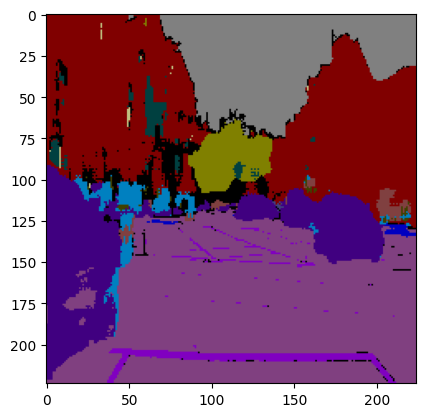

IoU for sample 0: 24.77940559387207


In [26]:
view_sample_predictions(model, test_loader_224x224, color_id, n=1) 

In [1]:
list_of_files = glob.glob(os.path.join(WEIGHTS_PATH, '*.pth')) # * means all if need specific format then *.csv
latest_weights = max(list_of_files, key=os.path.getctime)
start_epoch = load_weights(model, latest_weights) 

NameError: name 'glob' is not defined

In [ ]:
N_EPOCHS_360x480 = 20

for epoch in range(start_epoch + 1, start_epoch + N_EPOCHS_360x480 + 1):
    since = time.time()

    ### Train ###
    train_loss_360x480, train_err_360x480 = train(model, train_loader_360x480, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, train_loss_360x480, 1-train_err_360x480))    

    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss_360x480, val_err_360x480, val_IoU_360x480 = test(model, val_loader_360x480, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss_360x480, 1-val_err_360x480, val_IoU_360x480))
    print('Average IoU: ', val_IoU_360x480)
    
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model, WEIGHTS_PATH, epoch, val_loss_360x480, val_err_360x480)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

Epoch 41
Train - Loss: 0.6929, Acc: 0.7962
Train Time 5m 33s
Val - Loss: 1.3329 | Acc: 0.6014
Average IoU:  25.4375
Total Time 6m 41s

Epoch 42
Train - Loss: 0.6426, Acc: 0.8102
Train Time 5m 35s
Val - Loss: 0.7681 | Acc: 0.7784
Average IoU:  35.16666793823242
Total Time 6m 43s

Epoch 43
Train - Loss: 0.6276, Acc: 0.8141
Train Time 5m 33s
Val - Loss: 0.7631 | Acc: 0.7823
Average IoU:  34.5
Total Time 6m 42s

Epoch 44
Train - Loss: 0.5917, Acc: 0.8239
Train Time 5m 36s
Val - Loss: 4.4849 | Acc: 0.3790
Average IoU:  14.076923370361328
Total Time 6m 43s

Epoch 45
Train - Loss: 0.5827, Acc: 0.8257
Train Time 5m 33s
Val - Loss: 0.7163 | Acc: 0.7963
Average IoU:  35.61111068725586
Total Time 6m 41s



In [ ]:
test(model, test_loader_360x480, criterion, epoch=1)  

In [ ]:
view_sample_predictions(model, test_loader_360x480, color_id, n=1)

DROPOUT = 2!!

In [ ]:
densenet103_downblocks = [4, 5, 7, 10, 12]
densenet103_bottleneck = 15
densenet103_upblocks   = [12, 10, 7, 5, 4]
in_channels = 3
growth_rate = 16

model2 = DenseNet(in_channels=in_channels, down_blocks=densenet103_downblocks, 
                          up_blocks=densenet103_upblocks,
                          bottleneck_layers=densenet103_bottleneck, 
                          growth_rate=growth_rate, 
                          out_chans_first_conv=48,
                          n_classes=32, dropout=0.0).cuda()

In [ ]:
RESULTS_PATH = '/kaggle/working/results2'
WEIGHTS_PATH = '/kaggle/working/weights2'

Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
Path(WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)

In [ ]:
import time
optimizer = torch.optim.RMSprop(model2.parameters(), lr=LR, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss().cuda()

for epoch in range(1, N_EPOCHS_224x224 + 1):
    since = time.time()

    ### Train ###
    train_loss_224x224, train_err_224x224 = train(model2, train_loader_224x224, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, train_loss_224x224, 1-train_err_224x224))    

    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss_224x224, val_err_224x224, val_IoU_224x224 = test(model2, val_loader_224x224, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss_224x224, 1-val_err_224x224))
    print('Average IoU: ', val_IoU_224x224)
          
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model2, WEIGHTS_PATH, epoch, val_loss_224x224, val_err_224x224)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

In [ ]:
test(model2, test_loader_224x224, criterion, epoch=1, print_IoU=True)  

In [ ]:
view_sample_predictions(model2, test_loader_224x224, color_id, n=1) 

In [ ]:
list_of_files = glob.glob(os.path.join(WEIGHTS_PATH, '*.pth')) # * means all if need specific format then *.csv
latest_weights = max(list_of_files, key=os.path.getctime)
start_epoch = load_weights(model2, latest_weights)

In [ ]:
N_EPOCHS_360x480 = 20

for epoch in range(start_epoch + 1, start_epoch + N_EPOCHS_360x480 + 1):
    since = time.time()

    ### Train ###
    train_loss_360x480, train_err_360x480 = train(model2, train_loader_360x480, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, train_loss_360x480, 1-train_err_360x480))    

    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss_360x480, val_err_360x480, val_IoU_360x480 = test(model2, val_loader_360x480, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss_360x480, 1-val_err_360x480, val_IoU_360x480))
    print('Average IoU: ', val_IoU_360x480)
    
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model2, WEIGHTS_PATH, epoch, val_loss_360x480, val_err_360x480)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, epoch, DECAY_EVERY_N_EPOCHS)

In [ ]:
test(model2, test_loader_360x480, criterion, epoch=1) 

In [ ]:
view_sample_predictions(model2, test_loader_360x480, color_id, n=1)